# **CLUSTERING FISH SPECIES SAMPLING DATA WITH K-MEANS ALGORITHM**

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import SilhouetteVisualizer

## **Import Dataset**

In [ ]:
ikan = pd.read_csv('/content/fish_data.csv')
ikan

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31
...,...,...,...,...
4075,Sillaginopsis panijus,30.56,6.12,0.20
4076,Sillaginopsis panijus,29.66,6.11,0.21
4077,Sillaginopsis panijus,32.81,6.25,0.19
4078,Sillaginopsis panijus,29.78,6.11,0.21


In [ ]:
ikan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    4080 non-null   object 
 1   length     4080 non-null   float64
 2   weight     4080 non-null   float64
 3   w_l_ratio  4080 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.6+ KB


## **EDA**

In [ ]:
ikan.describe().T

,count,mean,std,min,25%,50%,75%,max
length,4080.0,17.353544,7.114684,6.36,11.3275,17.35,22.585,33.86
weight,4080.0,3.739875,1.040365,2.05,3.0700,3.31,4.100,6.29
w_l_ratio,4080.0,0.252782,0.123046,0.08,0.1700,0.19,0.340,0.64


In [ ]:
ikan.isna().sum()

,0
species,0
length,0
weight,0
w_l_ratio,0


In [ ]:
ikan.duplicated().sum()

np.int64(109)

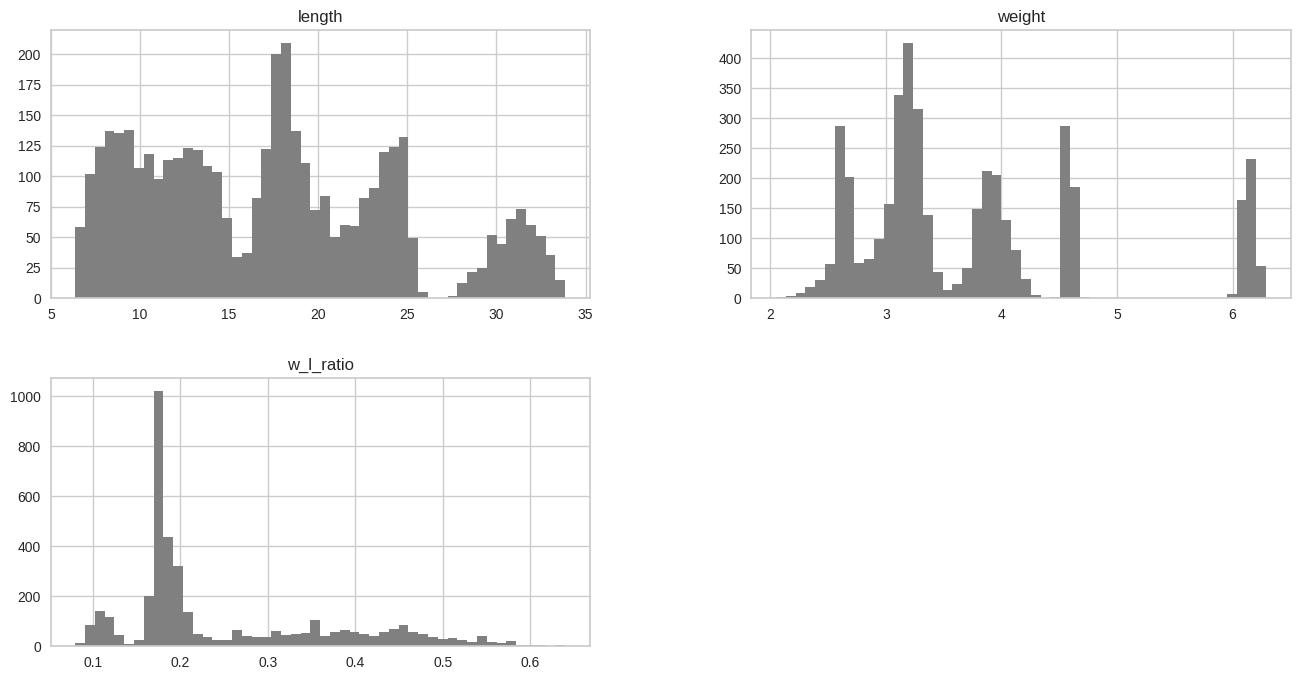

In [ ]:
# data distribution using a histogram
ikan.hist(bins=50, figsize=(16, 8), color="grey");

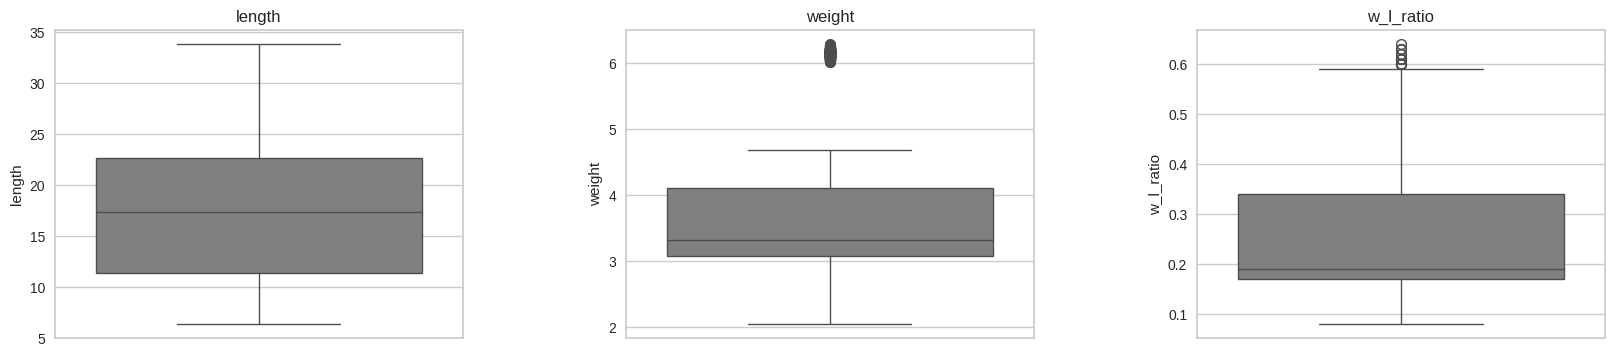

In [ ]:
# data distribution using boxplot
def box_plot(ikan):
    variables = ikan.select_dtypes(exclude='object').columns

    fig, axes = plt.subplots(1, len(variables), figsize=(20, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, var in enumerate(variables):
        sns.boxplot(y=var, data=ikan, color="grey", ax=axes[i])
        axes[i].set_title(var)

    plt.show()

box_plot(ikan)

### **Handling Outlier**

#### **Mencari outlier**

In [ ]:
def count_outlier_iqr(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return ((data < lower_bound) | (data > upper_bound)).sum()

# calculating outliers in each column with numeric/float data type.
outlier_counts = {}
for col in ikan.select_dtypes(include=['int64', 'float64']).columns:
  outlier_counts[col] = count_outlier_iqr(ikan[col])

outlier_counts_ikan = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outlier Count'])
outlier_counts_ikan

,Column,Outlier Count
0,length,0
1,weight,455
2,w_l_ratio,17


#### **Handling Outliers**

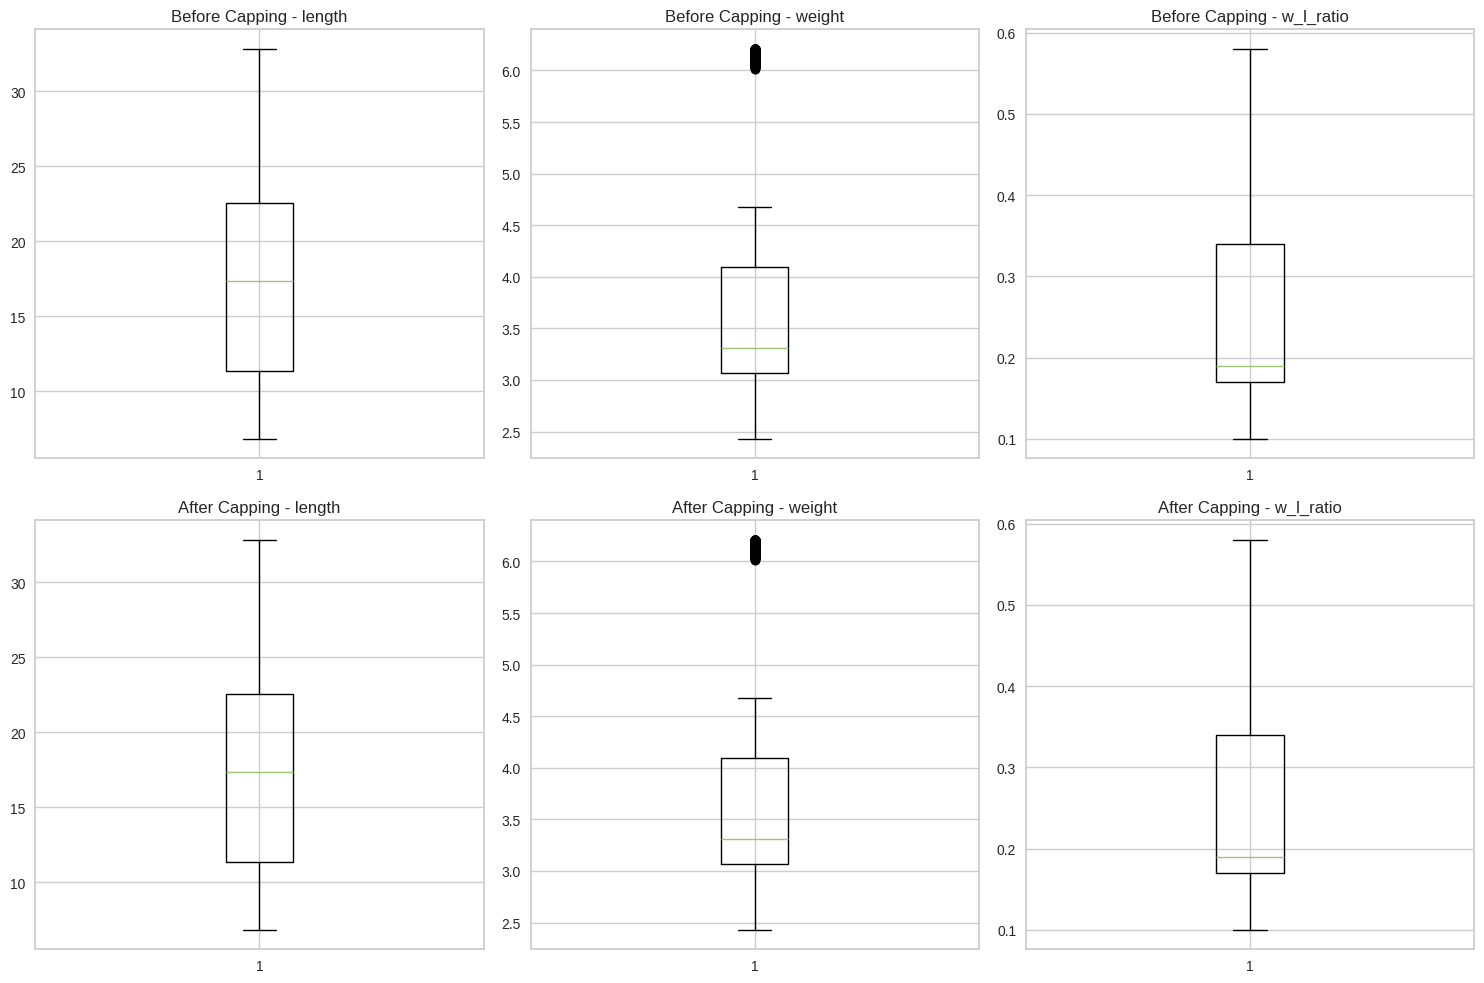

In [ ]:
def cap_outliers(ikan, column):
    lower_cap = ikan[column].quantile(0.01)
    upper_cap = ikan[column].quantile(0.99)
    ikan[column] = np.where(ikan[column] < lower_cap, lower_cap, ikan[column])
    ikan[column] = np.where(ikan[column] > upper_cap, upper_cap, ikan[column])
    return ikan

# Apply capping to numerical columns
numerical_cols = ['length', 'weight', 'w_l_ratio']
for col in numerical_cols:
    ikan = cap_outliers(ikan, col)

# Visualization before and after capping
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(ikan[col])
    plt.title(f'Before Capping - {col}')

    plt.subplot(2, 3, i+3)
    capped_df = cap_outliers(ikan.copy(), col)
    plt.boxplot(capped_df[col])
    plt.title(f'After Capping - {col}')

plt.tight_layout()
plt.show()

## **Clustering**

### **Scalling**

In [ ]:
features = ikan[['length', 'weight']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
X_scaled

array([[-0.94227267, -0.28003526],
       [-1.47032778, -0.4534165 ],
       [-1.26333018, -0.27040297],
       ...,
       [ 2.17677288,  2.37847712],
       [ 1.75010435,  2.2821542 ],
       [ 2.00920339,  2.31105108]])

In [ ]:
X_scaled.shape

(4080, 2)

### **Metode Elbow**

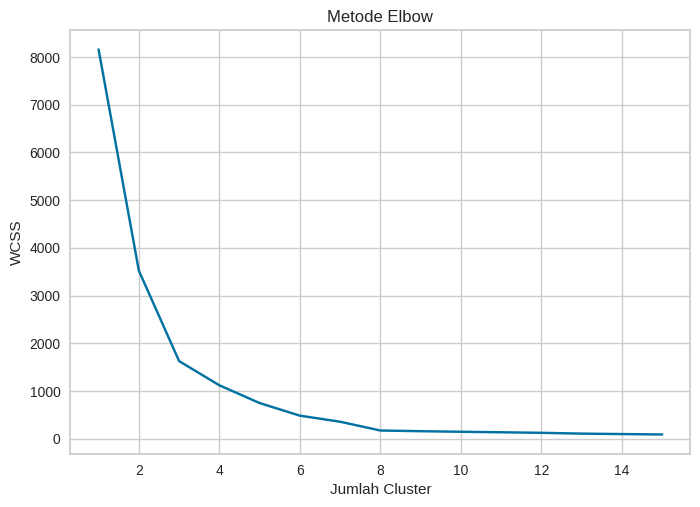

In [ ]:
wcss = []
for i in range (1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range (1, 16), wcss)
plt.title('Metode Elbow')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.show()

#### **2 CLUSTER**

In [ ]:
model1 =  KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_pred1 = model1.fit_predict(X_scaled)

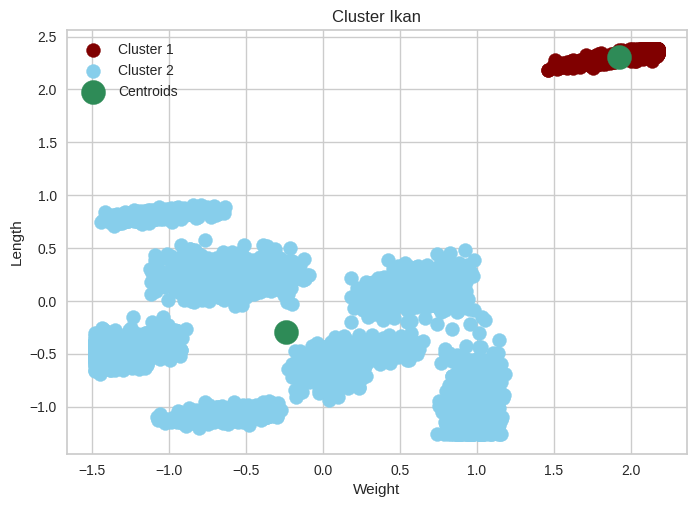

In [ ]:
plt.scatter(X_scaled[y_pred1 == 0, 0], X_scaled[y_pred1 == 0, 1],
           s =  100, c = 'maroon', label = 'Cluster 1')

plt.scatter(X_scaled[y_pred1 == 1, 0], X_scaled[y_pred1 == 1, 1],
           s =  100, c = 'skyblue', label = 'Cluster 2')

plt.scatter(model1.cluster_centers_[:, 0], model1.cluster_centers_[:, 1],
           s =  300, c = 'seagreen', label = 'Centroids')

plt.title('Cluster Ikan')
plt.xlabel('Weight')
plt.ylabel('Length')
plt.legend()
plt.show()

#### **Evaluasi**

In [ ]:
Evaluasi_KMeans = silhouette_score(X_scaled, y_pred1)

dbi_score1 = davies_bouldin_score(X_scaled, y_pred1)

print("Slihouette Score:", Evaluasi_KMeans)
print("Davies-Bouldin Index (DBI):", dbi_score1)

Slihouette Score: 0.6735008641102682
Davies-Bouldin Index (DBI): 0.3160898970545997


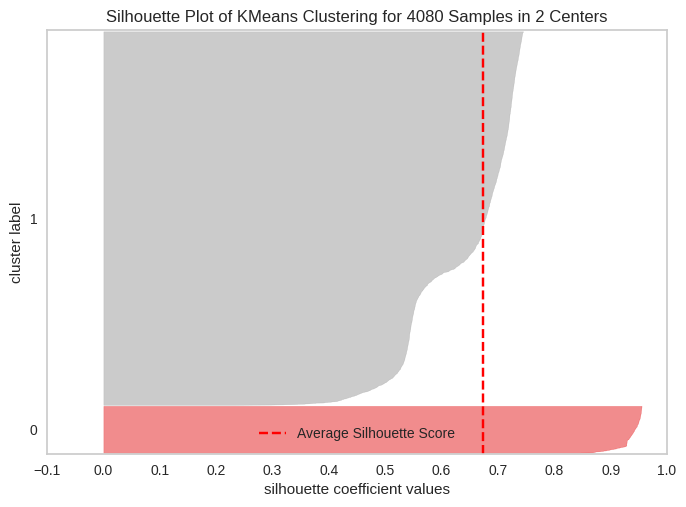

In [ ]:
silhouette_viz = SilhouetteVisualizer(model1)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()

#### **3 CLUSTER**

In [ ]:
model2 =  KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_pred2 = model2.fit_predict(X_scaled)

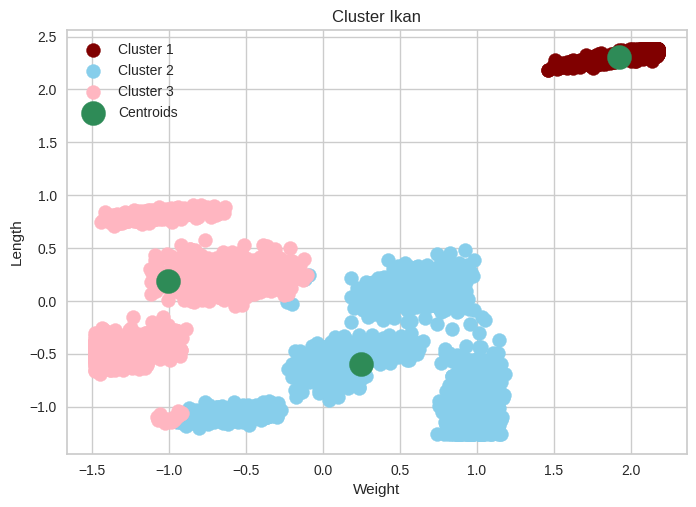

In [ ]:
plt.scatter(X_scaled[y_pred2 == 0, 0], X_scaled[y_pred2 == 0, 1],
           s =  100, c = 'maroon', label = 'Cluster 1')

plt.scatter(X_scaled[y_pred2 == 1, 0], X_scaled[y_pred2 == 1, 1],
           s =  100, c = 'skyblue', label = 'Cluster 2')

plt.scatter(X_scaled[y_pred2 == 2, 0], X_scaled[y_pred2 == 2, 1],
           s =  100, c = 'lightpink', label = 'Cluster 3')

plt.scatter(model2.cluster_centers_[:, 0], model2.cluster_centers_[:, 1],
           s =  300, c = 'seagreen', label = 'Centroids')

plt.title('Cluster Ikan')
plt.xlabel('Weight')
plt.ylabel('Length')
plt.legend()
plt.show()

#### **Evaluasi**

In [ ]:
Evaluasi_KMeans = silhouette_score(X_scaled, y_pred2)

dbi_score2 = davies_bouldin_score(X_scaled, y_pred2)

print("Slihouette Score:", Evaluasi_KMeans)
print("Davies-Bouldin Index (DBI):", dbi_score2)

Slihouette Score: 0.5501766121316175
Davies-Bouldin Index (DBI): 0.6104526792157233


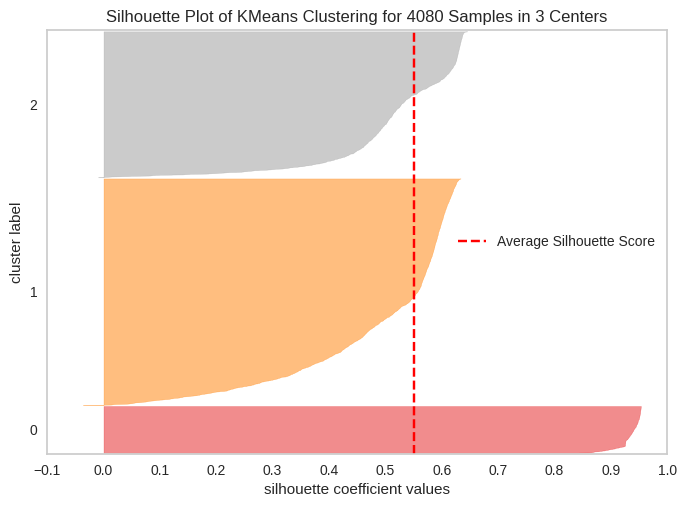

In [ ]:
silhouette_viz = SilhouetteVisualizer(model2)
silhouette_viz.fit(X_scaled)
plt.grid(False)
silhouette_viz.show()
plt.show()